In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import h3
import h3pandas
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import numpy as np

In [3]:
amsterdam_bike_paths = gpd.read_parquet("amsterdam_bike_paths_extended.parquet")

In [4]:
amsterdam_bike_paths.shape

(8618, 3)

In [5]:
amsterdam_bike_paths.head(1)

,id,tags,geometry
0,4264947,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.92236 52.36544, 4.92237 52.36543..."


<AxesSubplot: >

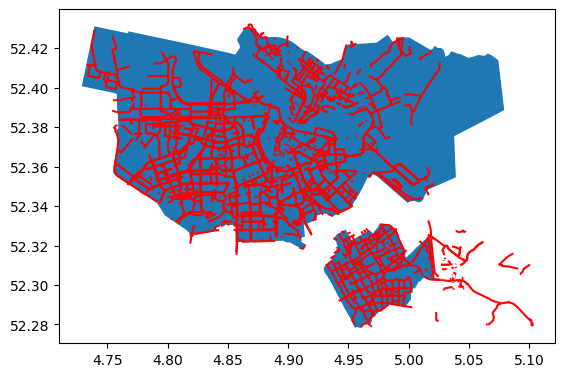

In [4]:
amsterdam_gdf = ox.geocode_to_gdf({'city': 'Amsterdam'})
fig, ax = plt.subplots(1,1)
amsterdam_gdf.plot(ax=ax)
amsterdam_bike_paths.plot(ax=ax, color="red")

<AxesSubplot: >

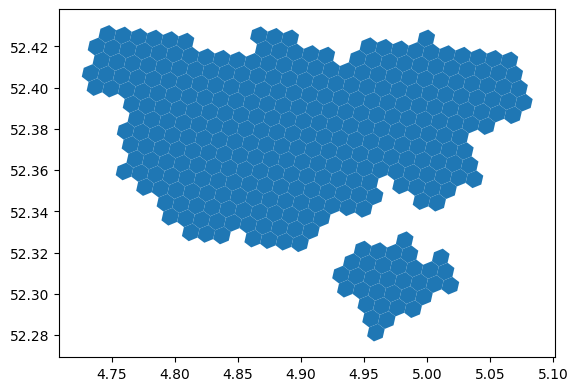

In [7]:
resolution = 8
amsterdam_gdf.h3.polyfill_resample(resolution).plot()

In [8]:
# Odległość od centrum miasta,

# · Powierzchnia terenów zielonych wewnątrz heksa,

# · Ilość budynków mieszkalnych czy punktów usługowych,

# · Gęstość zaludnienia,

# · Długość dróg o różnej klasyfikacji.

In [5]:
# amsterdam_gdf.columns
COLS_TO_DROP = ['bbox_north', 'bbox_south', 'bbox_east', 'bbox_west',
       'place_id', 'osm_type', 'osm_id', 'lat', 'lon', 'class', 'type',
       'place_rank', 'importance', 'addresstype', 'name', 'display_name']

In [8]:
amsterdam_gdf = ox.geocode_to_gdf({'city': 'Amsterdam'})
polygons = amsterdam_gdf.h3.polyfill_resample(resolution)
polygons = polygons.drop(COLS_TO_DROP, axis=1)
amsterdam_gdf = amsterdam_gdf.to_crs(28992)
# polygons = polygons.to_crs(28992)

<AxesSubplot: >

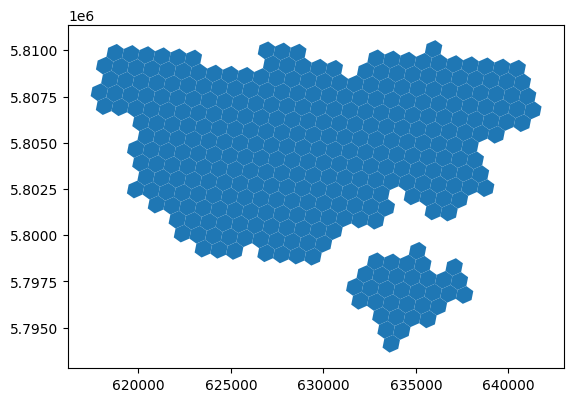

In [73]:
polygons.plot()

In [12]:
stop

NameError: name 'stop' is not defined

In [ ]:
# way - line
# node - point

In [ ]:
ox.features.features_from_polygon(polygons.iloc[0]["geometry"], {'width':True})

In [91]:
from joblib import Parallel, delayed
# areas = Parallel(n_jobs=-1)(delayed(get_green_area)(polygons["geometry"].iloc[i]) for i in range(polygons.shape[0]))
num_buildings = Parallel(n_jobs=-1)(delayed(get_number_of_buildings)(polygons["geometry"].iloc[i]) for i in range(polygons.shape[0]))

In [93]:
len(num_buildings)

352

In [94]:
# polygons["green_area_abs"] = areas
polygons["num_buildings"] = num_buildings

In [106]:
polygons[polygons["green_area_abs"]==0]

,index,geometry,green_area_abs,num_buildings
h3_polyfill,,,,
881969cf69fffff,0,"POLYGON ((5.06381 52.40893, 5.06222 52.40463, ...",0.0,0
881968268dfffff,0,"POLYGON ((4.81061 52.41125, 4.80903 52.40695, ...",0.0,15
881969cd69fffff,0,"POLYGON ((5.00360 52.36652, 5.00201 52.36222, ...",0.0,0
881969cd4dfffff,0,"POLYGON ((5.02462 52.37181, 5.02303 52.36751, ...",0.0,0
881969cd47fffff,0,"POLYGON ((5.01984 52.35892, 5.01825 52.35462, ...",0.0,0
881969c8dbfffff,0,"POLYGON ((5.03417 52.39759, 5.03258 52.39329, ...",0.0,0
881969cf0dfffff,0,"POLYGON ((5.07146 52.39527, 5.06986 52.39097, ...",0.0,0
881969cf25fffff,0,"POLYGON ((5.02939 52.38470, 5.02780 52.38040, ...",0.0,0
881969cf29fffff,0,"POLYGON ((5.05042 52.38998, 5.04883 52.38569, ...",0.0,0


<AxesSubplot: >

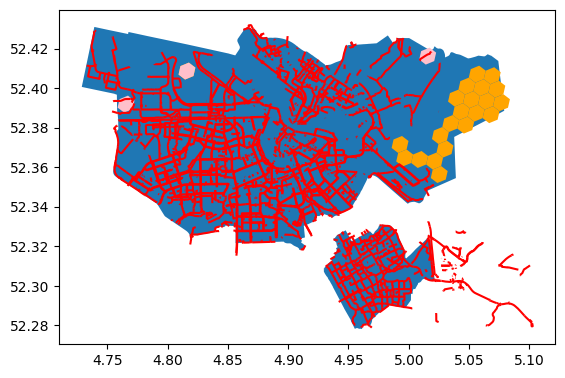

In [102]:
amsterdam_gdf = ox.geocode_to_gdf({'city': 'Amsterdam'})
fig, ax = plt.subplots(1,1)
amsterdam_gdf.plot(ax=ax)
amsterdam_bike_paths.plot(ax=ax, color="red")
polygons[polygons["green_area_abs"]==0]["geometry"].plot(ax=ax, color="orange")
polygons[polygons["num_buildings"]==15]["geometry"].plot(ax=ax, color="pink")

In [58]:
polygons["green_area_abs"].sum() / polygons["geometry"].to_crs(28992).area.sum()

0.32723107395946477

In [54]:
polygons["geometry"].to_crs(28992).area.sum() / 1000 / 1000

218.18215475778075

In [67]:
calculate_green_area(polygons["geometry"].iloc[0])

None


0

In [68]:
polygons

,index,geometry,green_area_abs
h3_polyfill,,,
881968269bfffff,0,"POLYGON ((118222.714 489186.600, 118111.693 48...",0
881968240bfffff,0,"POLYGON ((110960.550 491426.361, 110849.393 49...",0
881969c9b5fffff,0,"POLYGON ((120167.273 488245.893, 120056.286 48...",0
881969cf0dfffff,0,"POLYGON ((133508.381 489760.340, 133397.684 48...",0
881969c8a1fffff,0,"POLYGON ((125568.517 489137.870, 125457.649 48...",0
...,...,...,...
8819695319fffff,0,"POLYGON ((119757.068 484620.734, 119646.046 48...",0
881969c9e3fffff,0,"POLYGON ((120833.079 491108.938, 120722.126 49...",0
881969504bfffff,0,"POLYGON ((121369.615 482246.216, 121258.610 48...",0


In [38]:
polygons["green_area"].sum()

0.03949837649046431

In [103]:
def calculate_tag_area(geometry, tags_dict):
    try:
        features = ox.features.features_from_polygon(
            geometry, 
            tags=tags_dict
        )["geometry"]
        features = features.clip(geometry)    
    except Exception as e:
        print(e)
        return 0
    return features.to_crs(28992).area.sum()

def get_green_area(geometry):
    return calculate_tag_area(geometry, {'landuse': ['forest', 'grass', 'meadow', 'recreation_ground'], 'leisure': 'park'})

def get_buildings_area(geometry):
    return calculate_tag_area(geometry, {'building': 'yes'})

def get_bodies_of_water_area(geometry):
    return calculate_tag_area(geometry, {'natural': 'water'})

def get_number_of_buildings(geometry):
    try:
        buildings = ox.features.features_from_polygon(geometry, tags={'building': 'yes'})
    except Exception as e:
        print(e)
        return 0
    return buildings.shape[0]

# Further reading:
# https://wiki.openstreetmap.org/wiki/Map_features
# https://wiki.openstreetmap.org/wiki/Key:amenity
# https://wiki.openstreetmap.org/wiki/Key:highway

In [113]:
get_buildings_area(polygons.iloc[1]["geometry"])/1000/1000

0.08920706627309355

In [ ]:
polygons

In [ ]:
polygons["green_area"] = polygons["geometry"].apply(ox.features.features_from_polygon, axis=1, )

In [ ]:
# ox.features.features_from_polygon(polygons.iloc[0]["geometry"], {'incline':True})

# tags={'highway': True}
# tags={'landuse': ['forest', 'grass', 'meadow', 'recreation_ground'], 'leisure': 'park'}
# building_tags = {'building': ['residential', 'commercial']}
# warnings.filterwarnings("ignore", category=DeprecationWarning) 
# ox.features.features_from_polygon(polygons.iloc[2]["geometry"], tags={'building': ['residential', 'commercial']})


try:
    # display(ox.features.features_from_polygon(polygons.iloc[3]["geometry"], tags={'building': ['residential', 'commercial']}))
    print(np.sum(ox.features.features_from_polygon(polygons.iloc[3]["geometry"], 
                                      tags={'landuse': ['forest', 'grass', 'meadow', 'recreation_ground'], 'leisure': 'park'})["geometry"].area.values))
    
except: #InsufficientResponseError
    print("None")


In [16]:
polygons.to_crs(28992).area.iloc[3]

621479.3381058646

<AxesSubplot: >

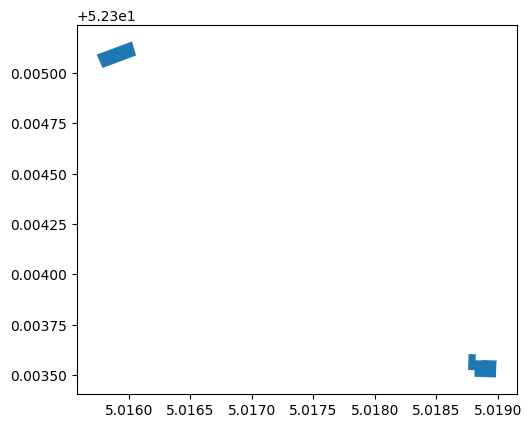

In [66]:
xd = ox.features.features_from_polygon(polygons.iloc[3]["geometry"], 
                                      tags={'building': ['residential', 'commercial']})
# xd.to_crs(28992).area.sum()
xd["geometry"].plot()
# xd

In [24]:
polygons.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
xd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [39]:
xd["geometry"].clip(polygons.iloc[3]["geometry"]).to_crs(28992).area.sum()

210140.27673747318

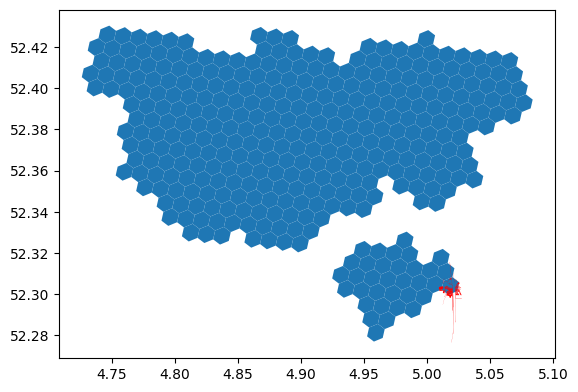

<AxesSubplot: >

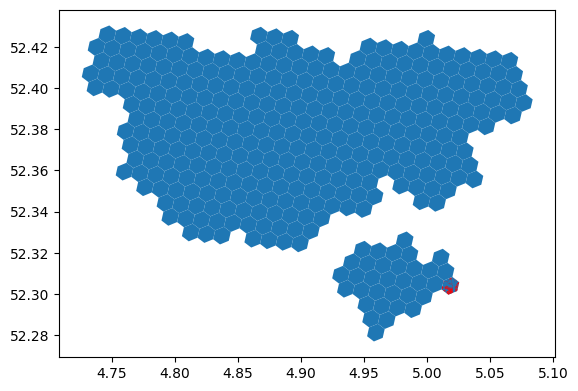

In [33]:
_, ax = plt.subplots(1,1)
polygons["geometry"].plot(ax=ax, zorder=1)
xd.plot(ax=ax,  color="red", zorder=2)
plt.show()

_, ax = plt.subplots(1,1)
polygons["geometry"].plot(ax=ax, zorder=1)
# xd.plot(ax=ax,  color="red", zorder=2)
xd["geometry"].clip(polygons.iloc[3]["geometry"]).plot(ax=ax,  color="red", zorder=2)

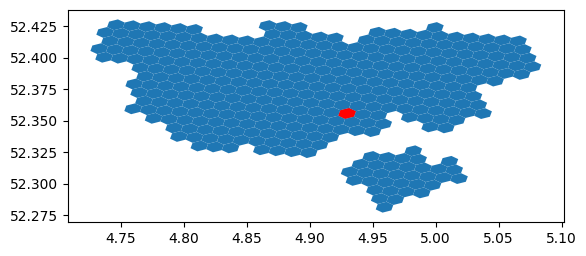

In [90]:
_, ax = plt.subplots(1,1)
polygons["geometry"].plot(ax=ax, zorder=1)
gpd.GeoSeries(polygons.iloc[1].loc["geometry"]).plot(ax=ax, zorder=1, color="red")
plt.show()